In [1]:
%tensorflow_version 1.x
# Clone git
%rm -rf archlectures
!git clone https://github.com/armaank/archlectures
%cd archlectures/generative/

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


TensorFlow 1.x selected.
Cloning into 'archlectures'...
remote: Enumerating objects: 12192, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 12192 (delta 7), reused 27 (delta 5), pack-reused 12157
Receiving objects: 100% (12192/12192), 120.89 MiB | 28.00 MiB/s, done.
Resolving deltas: 100% (512/512), done.
Checking out files: 100% (6342/6342), done.
/content/archlectures/generative
ganspace/      preprocess.py  setup.sh   stylgan2/
get_models.sh  README.md      stylclip/


In [3]:
%%sh
chmod 755 get_models.sh
./get_models.sh

ganspace
get_models.sh
models
preprocess.py
README.md
setup.sh
stylclip
stylgan2


./get_models.sh: 1: ./get_models.sh: !#/bin/bash: not found
mkdir: cannot create directory ‘./models’: File exists
mkdir: cannot create directory ‘Adaily_A’: File exists
mkdir: cannot create directory ‘Adaily_B’: File exists
mkdir: cannot create directory ‘torch_official’: File exists
Downloading...
From: https://drive.google.com/uc?id=1APtwpZj7uyzY4mRYMz9uoB2IgcXknlqB
To: /content/archlectures/generative/models/Adaily_A/torch_official/stylegan2_Adaily_1024.pt
133MB [00:01, 109MB/s]
mkdir: cannot create directory ‘torch_custom’: File exists
mkdir: cannot create directory ‘tf_official’: File exists
Downloading...
From: https://drive.google.com/uc?id=1qYWtbv9YvX3SGIVpW3493uY78hdiwJAh
To: /content/archlectures/generative/models/Adaily_A/tf_official/styleganv2-1024-010400.pkl
382MB [00:02, 181MB/s]
Downloading...
From: https://drive.google.com/uc?id=10bpWfzTdnx3f65sIYeIJVUn-2zAOlTiv
To: /content/archlectures/generative/models/Adaily_A/torch_custom/Gs.pth
122MB [00:00, 139MB/s] 
Downloading

In [4]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))
!pip install torch
!pip install fbpca boto3
!git submodule update --init --recursive
%cd ./ganspace/

<IPython.core.display.Javascript object>

/content/archlectures/generative/ganspace


StyleGAN2: Optimized CUDA op FusedLeakyReLU not available, using native PyTorch fallback.
StyleGAN2: Optimized CUDA op UpFirDn2d not available, using native PyTorch fallback.
StyleGAN2, style, a
../models/Adaily_A/torch_official/stylegan2_Adaily_1024.pt
Not cached
[08.05 18:58] Computing stylegan2-Adaily_A_style_ipca_c80_n1000000_w.npz
Reusing InstrumentedModel instance
Using W latent space
Feature shape: torch.Size([1, 512])
B=20, N=1000000, dims=512, N/dims=1953.1


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:289: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:263: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)
Fitting batches (NB=2000): 100%|##########| 500/500 [02:19<00:00,  3.60it/s]


Total time: 0:03:39.898293
Too few strips to create grid, creating just strips!


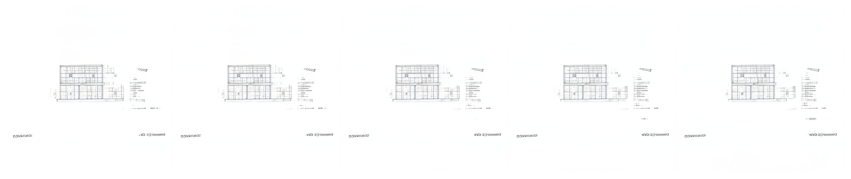

StyleGAN2, style, b
../models/Adaily_B/torch_official/stylegan2_Adaily_1024.pt
Not cached
[08.05 19:02] Computing stylegan2-Adaily_B_style_ipca_c80_n1000000_w.npz
Reusing InstrumentedModel instance
Using W latent space
Feature shape: torch.Size([1, 512])
B=20, N=1000000, dims=512, N/dims=1953.1


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:289: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:263: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)
Fitting batches (NB=2000): 100%|##########| 500/500 [02:25<00:00,  3.45it/s]


Total time: 0:03:47.391227
Too few strips to create grid, creating just strips!


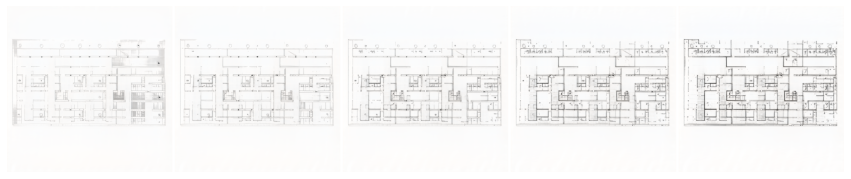

Done


In [5]:
import torch
import numpy as np
from os import makedirs
from types import SimpleNamespace
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import pickle

import sys
sys.path.insert(0, '..')
from models import get_instrumented_model, get_model
from notebooks.notebook_utils import create_strip, create_strip_centered, prettify_name, save_frames, pad_frames
from config import Config
from decomposition import get_or_compute

torch.autograd.set_grad_enabled(False)
torch.backends.cudnn.benchmark = True

has_gpu = torch.cuda.is_available()
device = torch.device('cuda' if has_gpu else 'cpu')
inst = None
out_root = Path('out/directions')
makedirs(out_root, exist_ok=True)
B = 5

# Model, layer, edit, layer_start, layer_end, class, sigma, idx, name, (example seeds)
configs = [        
    ('StyleGAN2', 'style', 'latent', 'w', 6, 8, 'Adaily_A', -20.0, 43, 'a', [140658858, 1887645531]),
    ('StyleGAN2', 'style', 'latent', 'w', 8, 9, 'Adaily_B', 9.0, 0, 'b', [266415229, 375122892]),
]

has_gpu = torch.cuda.is_available()
device = torch.device('cuda' if has_gpu else 'cpu')

num_imgs_per_example = 1

for config_id, (model_name, layer, mode, latent_space, l_start, l_end, classname, sigma, idx, title, seeds) in enumerate(configs[:]):
    print(f'{model_name}, {layer}, {title}')
    
    inst = get_instrumented_model(model_name, classname, layer, device, inst=inst) # reuse if possible
    model = inst.model
    
    if 'BigGAN' in model_name:
        model.truncation = 0.6
    elif 'StyleGAN2' in model_name:
        model.truncation = 0.7
        
    if latent_space == 'w':
        model.use_w()
    elif hasattr(model, 'use_z'):
        model.use_z()
    
    # Load or compute decomposition
    config = Config(
        output_class = classname,
        model = model_name,
        layer = layer,
        estimator = 'ipca',
        use_w = (latent_space == 'w'),
        n = 1_000_000
    )

    # Special case: BigGAN512-deep, gen_z: class-independent
    if model_name == 'BigGAN-512' and layer == 'generator.gen_z':
        config.output_class = 'husky' # chosen class doesn't matter
    
    dump_name = get_or_compute(config, inst)
    data = np.load(dump_name, allow_pickle=False)
    X_comp = data['act_comp']
    X_global_mean = data['act_mean']
    X_stdev = data['act_stdev']
    Z_global_mean = data['lat_mean']
    Z_comp = data['lat_comp']
    Z_stdev = data['lat_stdev']
    data.close()

    model.set_output_class(classname)
    feat_shape = X_comp[0].shape
    sample_dims = np.prod(feat_shape)
    
    # Transfer to GPU
    components = SimpleNamespace(
        X_comp = torch.from_numpy(X_comp).view(-1, *feat_shape).to('cuda').float(), #-1, 1, C, H, W
        X_global_mean = torch.from_numpy(X_global_mean).view(*feat_shape).to('cuda').float(), # 1, C, H, W
        X_stdev = torch.from_numpy(X_stdev).to('cuda').float(),
        Z_comp = torch.from_numpy(Z_comp).to('cuda').float(),
        Z_stdev = torch.from_numpy(Z_stdev).to('cuda').float(),
        Z_global_mean = torch.from_numpy(Z_global_mean).to('cuda').float(),
    )
    
    num_seeds = ((num_imgs_per_example - 1) // B + 1) * B # make divisible
    max_seed = np.iinfo(np.int32).max
    seeds = np.concatenate((seeds, np.random.randint(0, max_seed, num_seeds)))
    seeds = seeds[:num_seeds].astype(np.int32)
    latents = [model.sample_latent(1, seed=s) for s in seeds]
    
    # Range is exclusive, in contrast to notation in paper
    edit_start = l_start
    edit_end = model.get_max_latents() if l_end == -1 else l_end
    
    batch_frames = create_strip_centered(inst, mode, layer, latents, components.X_comp[idx],
                        components.Z_comp[idx], components.X_stdev[idx], components.Z_stdev[idx],
                        components.X_global_mean, components.Z_global_mean, sigma, edit_start, edit_end)
    save_frames(f'{config_id}_{title}_{mode}', model_name, out_root, batch_frames)
    
    edit_name = prettify_name(title)
    outidr = out_root / model_name / classname / edit_name
    makedirs(outidr, exist_ok=True)

    for ex, frames in enumerate(batch_frames):
        for i, frame in enumerate(frames):
            Image.fromarray(np.uint8(frame*255)).save(outidr / f'cmp{idx}_s{edit_start}_e{edit_end}_{seeds[ex]}_{i}.png')

    # Show first
    plt.figure(figsize=(15,15))
    plt.imshow(np.hstack(pad_frames(batch_frames[0])))
    plt.axis('off')
    plt.show()

print('Done')